#### Predicting claim frequencies (expected claim count per unit of exposure) expressed as rate. Is the base for key calculations: pricing, resrving, ruin probabilities and reinsurance.

In [115]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

In [116]:
sns.set_context("poster")
sns.set(rc={"figure.figsize": (20.,9.)})
sns.set_style("whitegrid")

In [117]:
claimsdf = pd.read_csv('/home/julian/Cursos/Ironhack/Proyectos/ProyectoFinal/freMTPL2freq.csv')

#### OUR DATA SET: A portfolio of 600 k car insurance policies

In [118]:
claimsdf.head(3)

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22


## EDA

In [119]:
claimsdf.shape

(678013, 12)

In [120]:
claimsdf.dtypes

IDpol         float64
ClaimNb         int64
Exposure      float64
Area           object
VehPower        int64
VehAge          int64
DrivAge         int64
BonusMalus      int64
VehBrand       object
VehGas         object
Density         int64
Region         object
dtype: object

In [121]:
claimsdf['empirical_freq'] = (claimsdf.ClaimNb / claimsdf.Exposure)

### ClaimNb (Claims counts)

#### We'll start with our target variable. Analyzing how the Claims distribute over the portfolio

In [122]:
claims_m = claimsdf.ClaimNb.mean()
claims_med = claimsdf.ClaimNb.median()
claims_mod = claimsdf.ClaimNb.mode()
claims_std = claimsdf.ClaimNb.std()
claims_m, claims_med, claims_mod,claims_std

(0.05324676665491664,
 0.0,
 0    0
 dtype: int64,
 0.24011733044675995)

In [123]:
claimsdf.ClaimNb.unique()

array([ 1,  2,  4,  3, 11,  0,  5,  6,  8, 16,  9])

In [124]:
data = {'ClaimNb': [0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 16],
        'year': [2000, 2001, 2002, 2001, 2002, 2003],
        'pop': [1.5, 1.7, 3.6, 2.4, 2.9, np.nan]}

/home/julian/miniconda3/envs/ironcon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


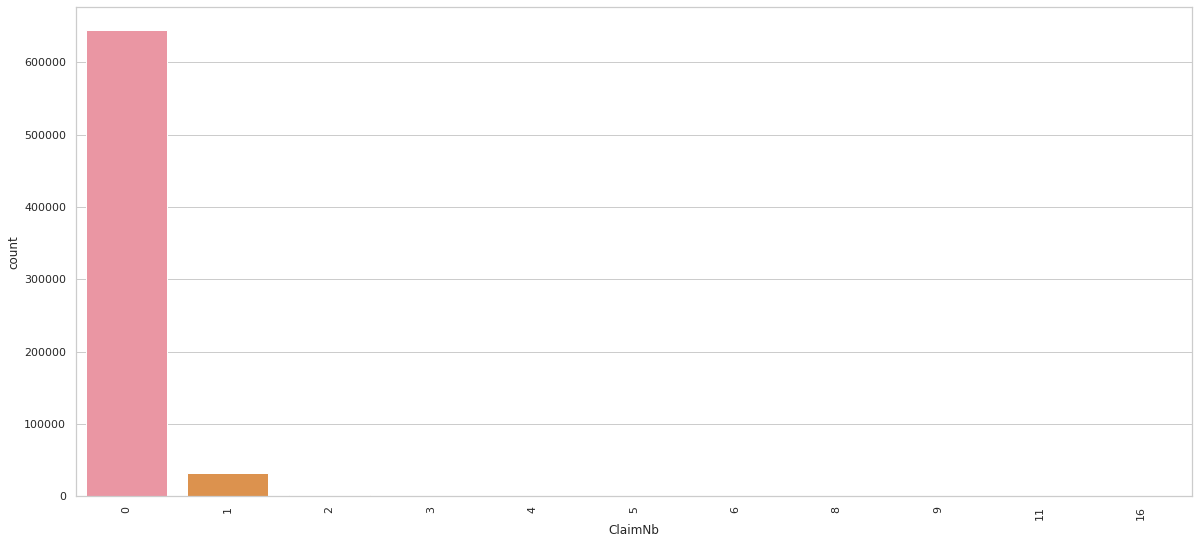

In [125]:
ax = sns.countplot(claimsdf.ClaimNb)
ax.tick_params(axis='x', rotation=90);

#### As we can see in the graph above, almost all claim counts is null, so we'll have to take this into account when we construct our model

### CATHEGORICAL VARIABLES - FEATURING ENGINEERING

#### We have 4 cathegorical variables, and 2 cathegorizable ones, namely Vehicle Age and Driver Age. We need to encode this cathegorical values for modelling pouposes (dummy-encode for regression structures or simply ordinal values for non parametric modelling like regression tree-style)

##### VEHICLE BRAND: Non ordinal , 11 CLASES

In [126]:
claimsdf.VehBrand.unique()

array(['B12', 'B6', 'B3', 'B2', 'B5', 'B10', 'B14', 'B13', 'B4', 'B1',
       'B11'], dtype=object)

In [127]:
claimsdf.VehBrand.value_counts()

B12    166024
B1     162736
B2     159861
B3      53395
B5      34753
B6      28548
B4      25179
B10     17707
B11     13585
B13     12178
B14      4047
Name: VehBrand, dtype: int64

In [128]:
dic_brands = {'B1': 1, 'B2': 2, 'B3': 3, 'B4': 4, 'B5': 5, 'B6': 6, 'B10': 7, 'B11': 8, 'B12': 9, 'B13': 10, 'B14': 11}

In [129]:
claimsdf.VehBrand = claimsdf.VehBrand.map(dic_brands)

##### VEHICLE GAS: Non ordinal, binary class

In [130]:
claimsdf.VehGas.unique()

array(['Regular', 'Diesel'], dtype=object)

In [131]:
claimsdf.VehGas.value_counts()

Regular    345877
Diesel     332136
Name: VehGas, dtype: int64

In [132]:
claimsdf = pd.get_dummies(claimsdf, columns=['VehGas'], drop_first=True)

##### AREA Code: Ordinal, 6 CLASES

In [133]:
claimsdf.Area.unique()

array(['D', 'B', 'E', 'C', 'F', 'A'], dtype=object)

In [134]:
claimsdf.Area.value_counts()

C    191880
D    151596
E    137167
A    103957
B     75459
F     17954
Name: Area, dtype: int64

In [135]:
dic_area = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6}
claimsdf.Area = claimsdf.Area.map(dic_area)

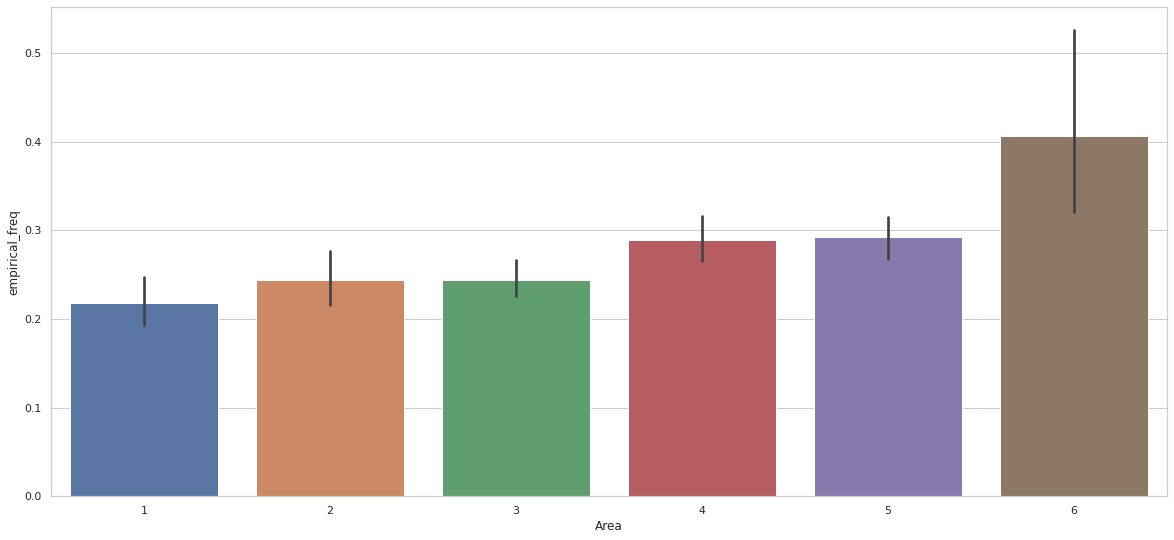

In [136]:
#sns.barplot(x="Area", y="empirical_freq", data=claimsdf, order=claimsdf.sort_values('empirical_freq').Area);
sns.barplot(x="Area", y="empirical_freq", data=claimsdf);

#### As we can see above, there's seem to be an ordinal value in the area code with respect to the empirical frequencies

##### REGION: Non ordinal,  22 CLASES, Que regiones?

In [137]:
claimsdf.Region.unique()

array(['R82', 'R22', 'R72', 'R31', 'R91', 'R52', 'R93', 'R11', 'R24',
       'R94', 'R83', 'R54', 'R26', 'R53', 'R73', 'R42', 'R25', 'R21',
       'R41', 'R43', 'R74', 'R23'], dtype=object)

In [138]:
dic_region = {'R11': 1, 'R21': 2, 'R22': 3, 'R23': 4, 'R24': 5, 'R25': 6, 'R26': 7, 
              'R31': 8, 'R41': 9, 'R42': 10, 'R43': 11, 'R52': 12, 'R53': 13, 'R54': 14,
              'R72': 15, 'R73': 16, 'R74': 17, 'R82': 18, 'R83': 19, 'R91': 20, 'R93': 21, 
              'R94': 22}

In [139]:
claimsdf.Region = claimsdf.Region.map(dic_region)

In [140]:
region = pd.DataFrame(claimsdf.Region.value_counts())
region

,Region
5,160601
18,84752
21,79315
1,69791
13,42122
12,38751
20,35805
15,31329
8,27285
14,19046


#### VEHICLE POWER (Ordered cathegorical according to the data source)

In [141]:
claimsdf.VehPower.unique()

array([ 5,  6,  7,  4,  9, 15,  8, 10, 12, 11, 14, 13])

In [142]:
def vehpower_gr(x):
    """
    ARG: A number
    Returns: If is different from 12, 13, 14 or 15, returns the number, 
    otherwise, returns 12
    """
    if x in [12, 13, 14, 15]:
        x_ = 12
        return x_
    else:
        return x

In [143]:
claimsdf['VehPower_'] = claimsdf.VehPower.apply(lambda x: vehpower_gr(x))

In [144]:
veh_power = pd.DataFrame(claimsdf.VehPower_.value_counts())
veh_power

,VehPower_
6,148976
7,145401
5,124821
4,115349
8,46956
10,31354
9,30085
11,18352
12,16719


#### VEHICLE AGE

##### Vehicle Age and Driver Age should be cathegorized in a way such that each resulting class is as homogeneous as possible in the underlying frequency. For GLM modeling approach, as the frequencies are non-linearly related to those features, we should partition them and then treat them as (nominal) categorical variables.

/home/julian/miniconda3/envs/ironcon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


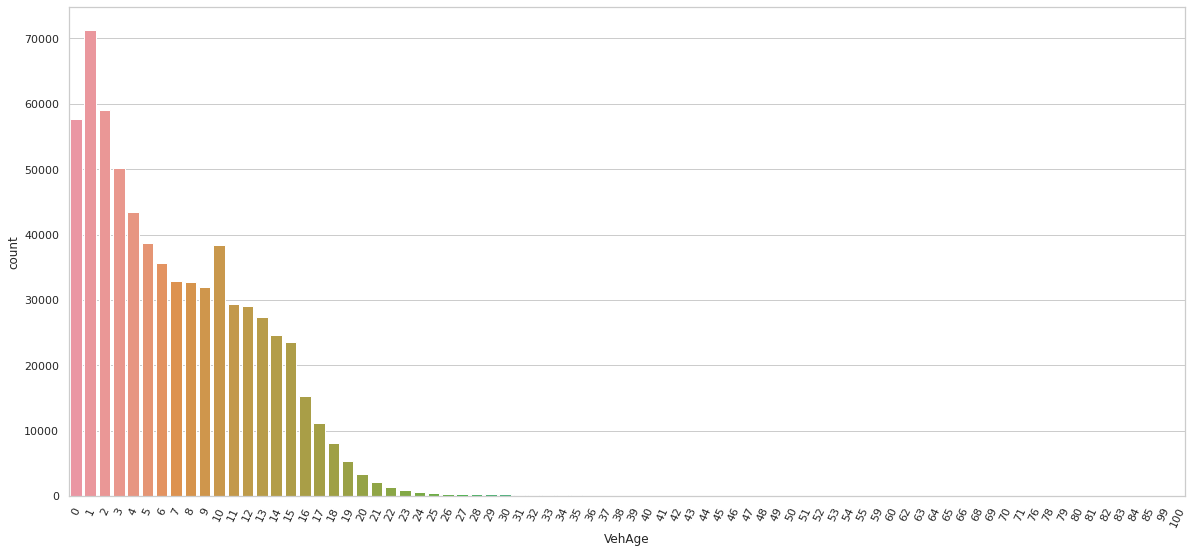

In [145]:
ax = sns.countplot(claimsdf['VehAge'])
ax.tick_params(axis='x', rotation=65);

#### As we can see in the above graph, almost all cars in the data set are under 20 years old, we will group them in 3 different classes

In [146]:
def vehage_gr(x):
    """
    ARG: A number
    Returns: If x belongs to [0,1] -> 1
             If x belongs to (1,10] -> 2
             If x belongs to (10,+inf) -> 3
    """
    if x in range(2):
        x_ = 1
        return x_
    elif x in range(1,11):
        x_ = 2
        return x_
    else:
        return 3

In [147]:
claimsdf['VehAge_'] = claimsdf.VehAge.apply(lambda x: vehage_gr(x))

In [148]:
veh_age = pd.DataFrame(claimsdf.VehAge_.value_counts())
veh_age

,VehAge_
2,363208
3,185782
1,129023


#### DRIVER AGE

#### We'll repeat the same procedure for the drivers age, by grouping them in 8 different clases 

/home/julian/miniconda3/envs/ironcon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


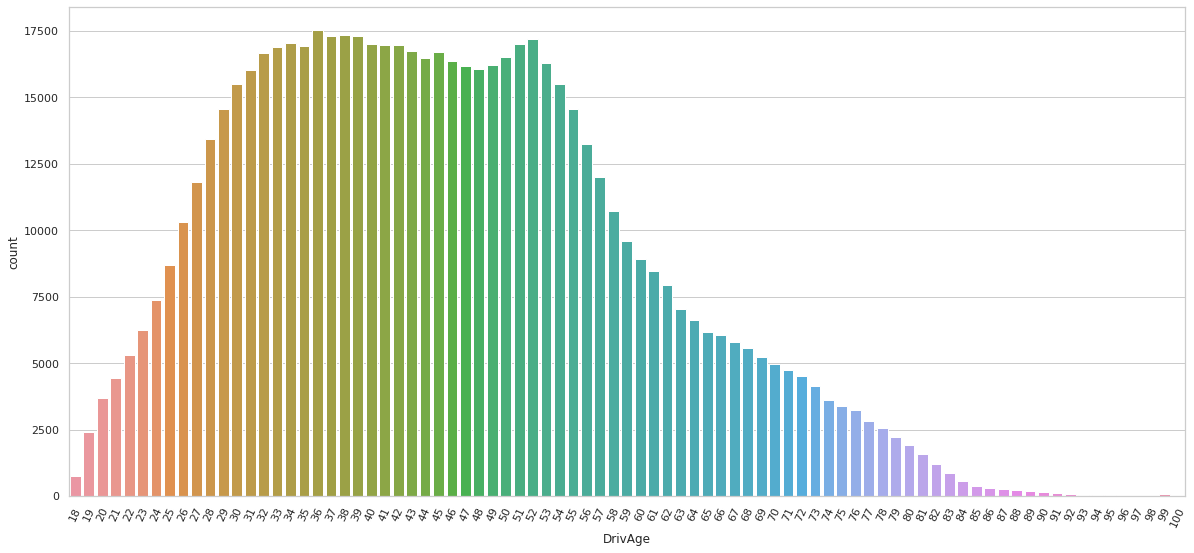

In [149]:
ax = sns.countplot(claimsdf.DrivAge)
ax.tick_params(axis='x', rotation=65)

In [150]:
def drivage_gr(x):
    """
    ARG: A number
    Returns: Assings a class (from 1 to 8) if x belongs to the specified ranges
    """
    if x in range(18,21):
        x_ = 1
        return x_
    elif x in range(21,26):
        x_ = 2
        return x_
    elif x in range(26,31):
        x_ = 3
        return x_
    elif x in range(31,41):
        x_ = 4
        return x_
    elif x in range(41,51):
        x_ = 5
        return x_
    elif x in range(51,61):
        x_ = 6
        return x_
    elif x in range(61,71):
        x_ = 7
        return x_

    else:
        return 8

In [151]:
claimsdf['DrivAge_'] = claimsdf.DrivAge.apply(lambda x: drivage_gr(x))

In [152]:
drivers_age = pd.DataFrame(claimsdf.DrivAge_.value_counts())
drivers_age

,DrivAge_
4,170097
5,165185
6,135014
3,65594
7,63863
8,39365
2,32079
1,6816


#### Now, we just keep the new transformed columns, and drop the ID of the policies because it makes no sense as an explanatory variable to predict the frequency of claims.

In [158]:
claimsdf.drop(columns=['IDpol', 'VehPower', 'VehAge', 'DrivAge'], inplace=True)

KeyError: "['IDpol' 'VehPower' 'VehAge' 'DrivAge'] not found in axis"

### VARIABLES CONTINUAS 

#### DENSITY

In [154]:
claimsdf.Density.value_counts()

27000    10515
3317      9891
1313      7157
9307      5986
3744      5540
         ...  
1036         2
1013         2
1126         2
869          1
1651         1
Name: Density, Length: 1607, dtype: int64

#### BONUSMALUS, expresado en que unidades?

In [155]:
claimsdf.BonusMalus.unique()

array([ 50,  68,  90, 100,  76,  56,  71,  52,  85,  51,  54,  80,  66,
        72,  55,  53,  60,  95,  64,  57,  58,  91,  62,  97,  74,  61,
        63, 105, 106,  88,  67,  86,  75,  59,  77, 118,  73, 125,  70,
       120,  69,  78,  82, 112,  65,  81, 115,  93,  83,  84,  92, 101,
       109, 110,  79, 102, 140, 147, 156, 108,  96, 107, 132, 148,  87,
       116, 114, 177, 139, 119, 165, 103, 122, 128, 133, 196, 228,  89,
       113,  99, 126, 173, 175, 111, 195, 149, 117, 138, 104, 163, 187,
       158, 230, 185, 198, 151,  94, 208, 176, 136,  98, 135, 142, 162,
       144, 121, 141, 183, 166, 130, 123, 174, 218, 124, 190])

In [156]:
claimsdf.BonusMalus.value_counts()

50     384156
100     19530
68      18791
72      18580
76      18226
        ...  
135         1
136         1
230         1
208         1
151         1
Name: BonusMalus, Length: 115, dtype: int64

In [157]:
claimsdf.to_csv('claimsdf_1.csv', index = False)